# Pulse Code Modulation

Made by -
- Devansh Sangule ( 22/11/EE/003 )
- Aman Kumar ( 22/11/EE/047 )
- Ritanshu Prasad ( 22/11/EE/058 )

### Importing libraries

In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import soundfile as sf

### Loading the audio file

In [2]:
audio_path = 'Recording.wav'
y, sr = librosa.load(audio_path, sr=None)


### Finding out the peak frequency

In [3]:
# Perform Fourier Transform to convert the signal to the frequency domain
fft_result = np.fft.fft(y)

# Calculate the corresponding frequencies
frequencies = np.fft.fftfreq(len(fft_result), 1 / sr)

# Get the magnitude of the FFT result
magnitude = np.abs(fft_result)

# Find the peak frequency (index of the maximum magnitude)
peak_frequency = frequencies[np.argmax(magnitude)]

print(f"Peak Frequency Component: {peak_frequency:.2f} Hz")

Peak Frequency Component: 981.15 Hz


### Sampling the audio signal

In [4]:
nyquist_rate = 2 * peak_frequency

undersampled_sr = 0.6 * nyquist_rate
target_sr = nyquist_rate
oversampled_sr = 1.4 * nyquist_rate

In [5]:
y_undersampled = librosa.resample(y, orig_sr=sr, target_sr=undersampled_sr)
y_resampled = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
y_oversampled = librosa.resample(y, orig_sr=sr, target_sr=oversampled_sr)

### Normalizing the sampled signal

In [6]:
y_under_normalized = y_undersampled / np.max(np.abs(y_undersampled))
y_normalized = y_resampled / np.max(np.abs(y_resampled))
y_over_normalized = y_oversampled / np.max(np.abs(y_oversampled))

### Quantization of the normalized signal

In [7]:
num_bits = 8     # 8-bit quantization, 2^8 = 256 levels
quantization_levels = 2 ** num_bits

In [8]:
y_under_quantized = np.round((y_under_normalized + 1) * (quantization_levels / 2 - 1))
y_quantized = np.round((y_normalized + 1) * (quantization_levels / 2 - 1))
y_over_quantized = np.round((y_over_normalized + 1) * (quantization_levels / 2 - 1))

In [9]:
# Ensuring the quantized signal is within the range
y_under_quantized = np.clip(y_under_quantized, 0, quantization_levels - 1)
y_quantized = np.clip(y_quantized, 0, quantization_levels - 1)
y_over_quantized = np.clip(y_over_quantized, 0, quantization_levels - 1)

In [10]:
# Convert to integers
y_under_quantized = y_under_quantized.astype(np.int16)
y_quantized = y_quantized.astype(np.int16)
y_over_quantized = y_over_quantized.astype(np.int16)

### Encoding to Binary PCM format

In [11]:
y_under_binary_pcm = [np.binary_repr(int(sample), width=num_bits) for sample in y_under_quantized]
y_binary_pcm = [np.binary_repr(int(sample), width=num_bits) for sample in y_quantized]
y_over_binary_pcm = [np.binary_repr(int(sample), width=num_bits) for sample in y_over_quantized]

In [12]:
# Convert binary PCM strings to an array of 0s and 1s (for use in graph later)
undersampled_binary_matrix = []
for binary_string in y_under_binary_pcm:
    for i in range(0,num_bits):
        undersampled_binary_matrix.append(int(binary_string[i]))

binary_matrix = []
for binary_string in y_binary_pcm:
    for i in range(0,num_bits):
        binary_matrix.append(int(binary_string[i]))

oversampled_binary_matrix = []
for binary_string in y_over_binary_pcm:
    for i in range(0,num_bits):
        oversampled_binary_matrix.append(int(binary_string[i]))

### [NYQUIST] Visualizing the original, sampled, quantized and PCM signals

In [13]:
# Choose the range of samples to zoom in on
start_sample_time = 0.40
sample_size = 40

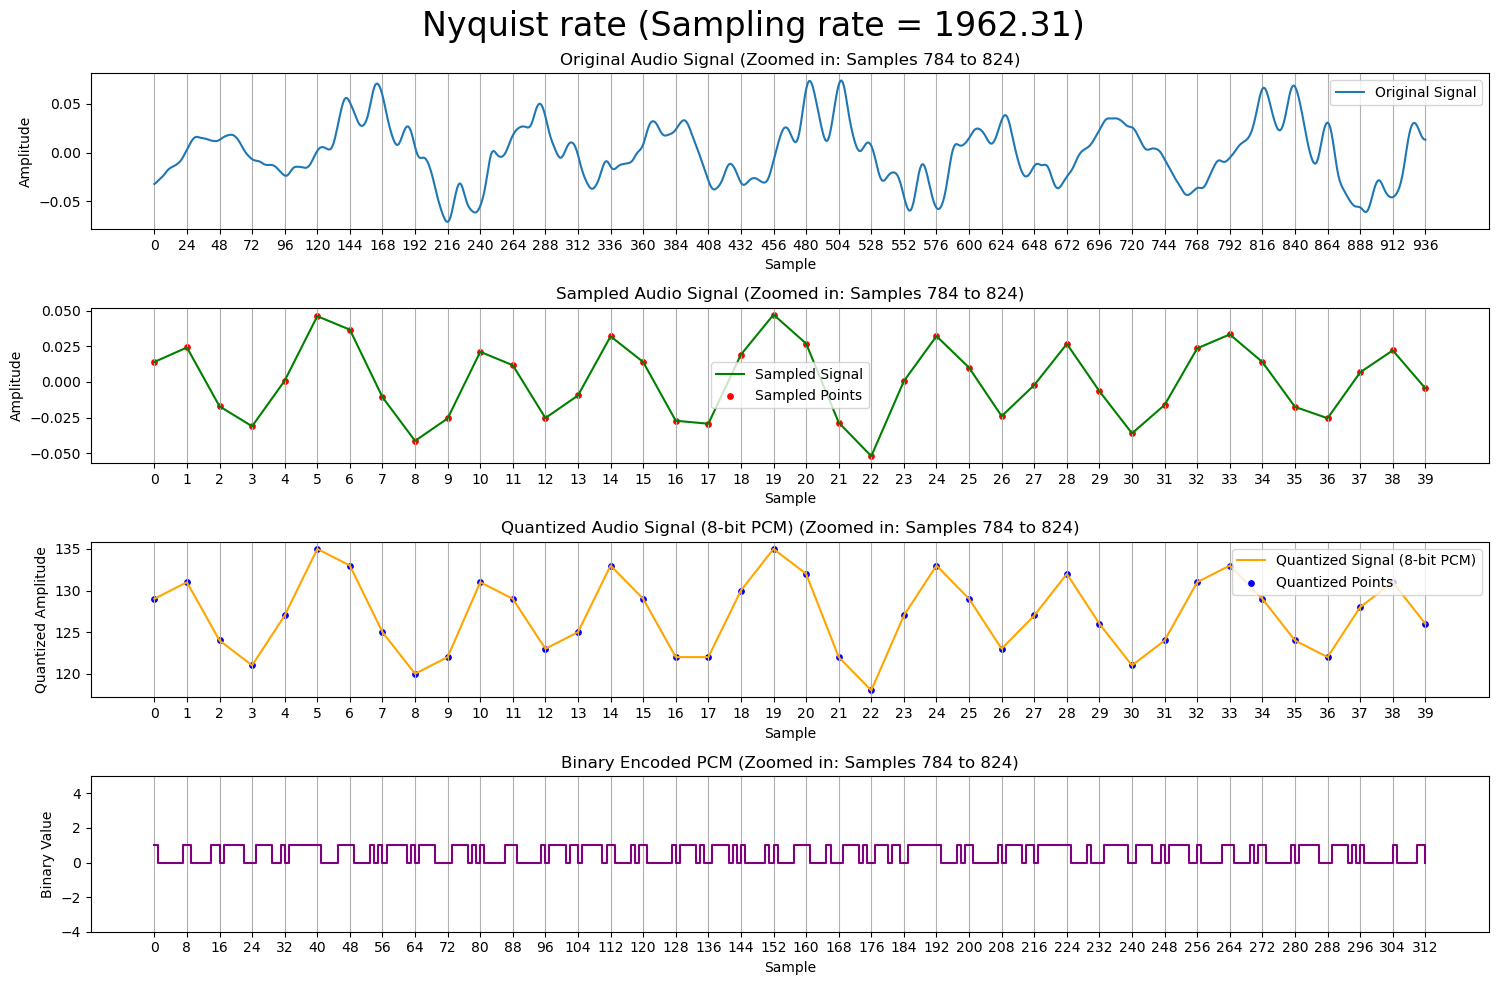

In [14]:
start_sample = int(start_sample_time * target_sr)
end_sample = start_sample + sample_size
c_r = int(sr/target_sr)

plt.figure(figsize=(15, 10))

# Plot 1: Original Signal
plt.subplot(4, 1, 1)
plt.plot(y[start_sample*c_r:(end_sample-1)*c_r+1], label="Original Signal")
plt.xticks(np.arange(0, sample_size*c_r, c_r))
plt.title(f"Original Audio Signal (Zoomed in: Samples {start_sample} to {end_sample})")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True, axis="x")
plt.legend()

# Plot 2: Sampled Signal
plt.subplot(4, 1, 2)
plt.plot(y_resampled[start_sample:end_sample], label="Sampled Signal", color='green')
plt.scatter(np.arange(0, sample_size), y_resampled[start_sample:end_sample], color='red', label="Sampled Points", s=15)
plt.xticks(np.arange(0, sample_size, 1))
plt.title(f"Sampled Audio Signal (Zoomed in: Samples {start_sample} to {end_sample})")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True, axis="x")
plt.legend()

# Plot 3: Quantized Signal
plt.subplot(4, 1, 3)
plt.plot(y_quantized[start_sample:end_sample], label="Quantized Signal (8-bit PCM)", color='orange')
plt.scatter(np.arange(0, sample_size), y_quantized[start_sample:end_sample], color='blue', label="Quantized Points", s=15)
plt.xticks(np.arange(0, sample_size, 1))
plt.title(f"Quantized Audio Signal (8-bit PCM) (Zoomed in: Samples {start_sample} to {end_sample})")
plt.xlabel("Sample")
plt.ylabel("Quantized Amplitude")
plt.grid(True, axis="x")
plt.legend()

# Plot 4: Binary Encoded PCM
plt.subplot(4, 1, 4)
plt.step(np.arange(0, (sample_size-1)*num_bits+1), binary_matrix[start_sample*num_bits:(end_sample-1)*num_bits+1], where='post', color='purple')
plt.xticks(np.arange(0, sample_size*num_bits, num_bits))
plt.title(f"Binary Encoded PCM (Zoomed in: Samples {start_sample} to {end_sample})")
plt.xlabel("Sample")
plt.ylabel("Binary Value")
plt.ylim(-(sample_size/num_bits)+1, sample_size/num_bits)
plt.grid(True, axis="x")

plt.suptitle(f"Nyquist rate (Sampling rate = {target_sr:.2f})", fontsize=24)

plt.tight_layout()
plt.show()

### [UNDERSAMPLED] Visualizing the original, sampled, quantized and PCM signals

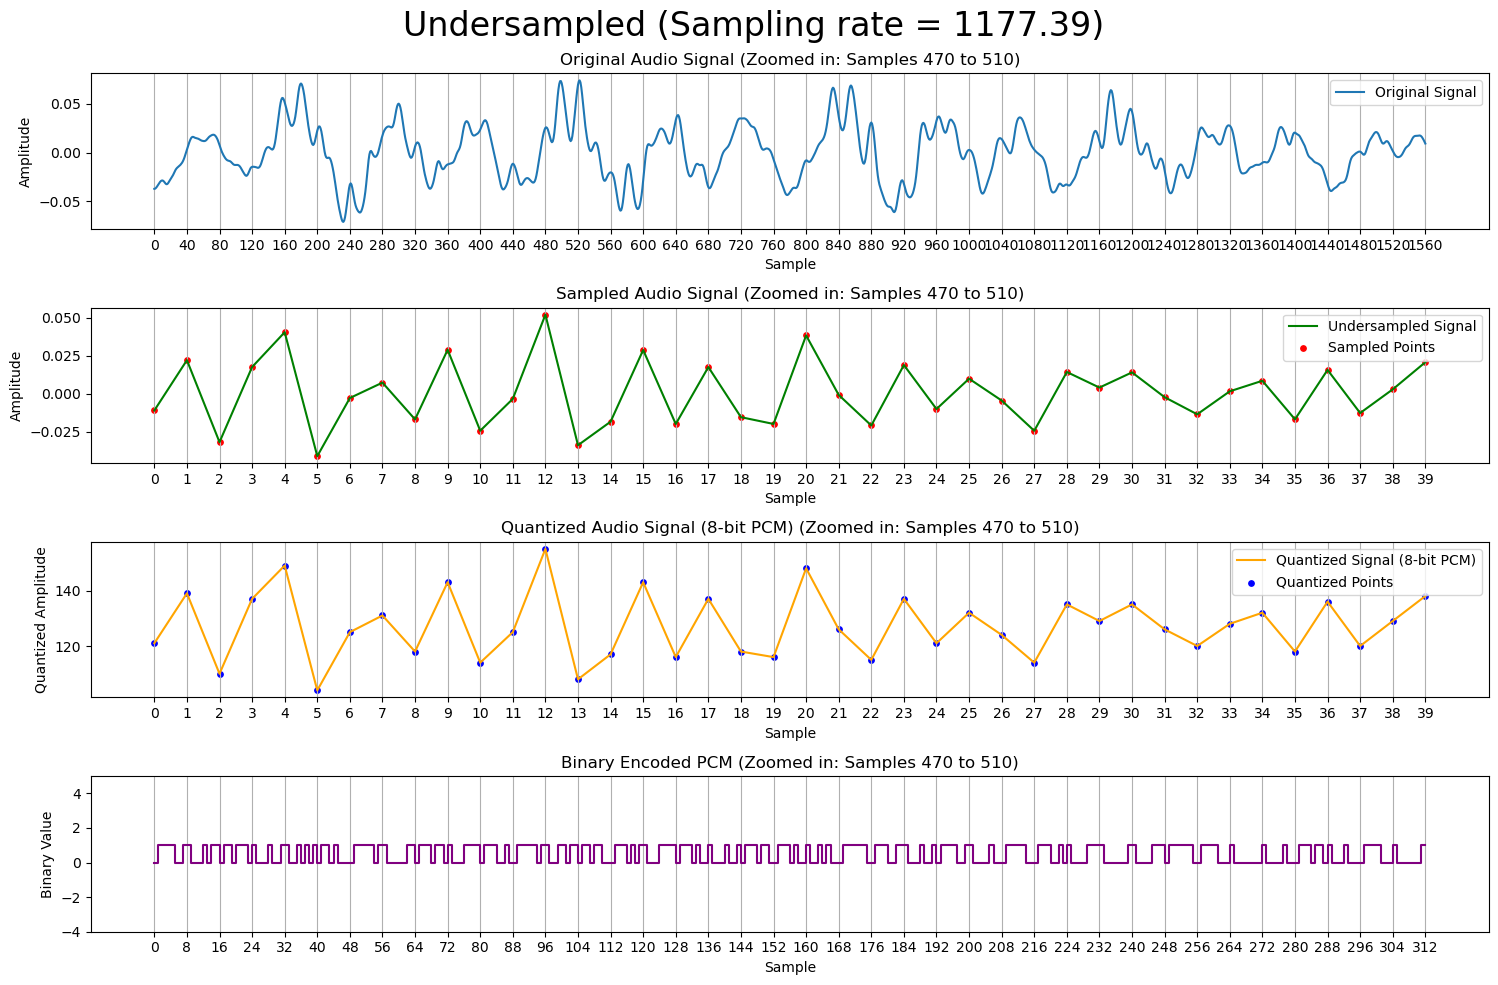

In [15]:
start_sample = int(start_sample_time * undersampled_sr)
end_sample = start_sample + sample_size
c_r = int(sr/undersampled_sr)

plt.figure(figsize=(15, 10))

# Plot 1: Original Signal
plt.subplot(4, 1, 1)
plt.plot(y[start_sample*c_r:(end_sample-1)*c_r+1], label="Original Signal")
plt.xticks(np.arange(0, sample_size*c_r, c_r))
plt.title(f"Original Audio Signal (Zoomed in: Samples {start_sample} to {end_sample})")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True, axis="x")
plt.legend()

# Plot 2: Sampled Signal
plt.subplot(4, 1, 2)
plt.plot(y_undersampled[start_sample:end_sample], label="Undersampled Signal", color='green')
plt.scatter(np.arange(0, sample_size), y_undersampled[start_sample:end_sample], color='red', label="Sampled Points", s=15)
plt.xticks(np.arange(0, sample_size, 1))
plt.title(f"Sampled Audio Signal (Zoomed in: Samples {start_sample} to {end_sample})")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True, axis="x")
plt.legend()

# Plot 3: Quantized Signal
plt.subplot(4, 1, 3)
plt.plot(y_under_quantized[start_sample:end_sample], label="Quantized Signal (8-bit PCM)", color='orange')
plt.scatter(np.arange(0, sample_size), y_under_quantized[start_sample:end_sample], color='blue', label="Quantized Points", s=15)
plt.xticks(np.arange(0, sample_size, 1))
plt.title(f"Quantized Audio Signal (8-bit PCM) (Zoomed in: Samples {start_sample} to {end_sample})")
plt.xlabel("Sample")
plt.ylabel("Quantized Amplitude")
plt.grid(True, axis="x")
plt.legend()

# Plot 4: Binary Encoded PCM
plt.subplot(4, 1, 4)
plt.step(np.arange(0, (sample_size-1)*num_bits+1), undersampled_binary_matrix[start_sample*num_bits:(end_sample-1)*num_bits+1], where='post', color='purple')
plt.xticks(np.arange(0, sample_size*num_bits, num_bits))
plt.title(f"Binary Encoded PCM (Zoomed in: Samples {start_sample} to {end_sample})")
plt.xlabel("Sample")
plt.ylabel("Binary Value")
plt.ylim(-(sample_size/num_bits)+1, sample_size/num_bits)
plt.grid(True, axis="x")

plt.suptitle(f"Undersampled (Sampling rate = {undersampled_sr:.2f})", fontsize=24)

plt.tight_layout()
plt.show()

### [OVERSAMPLED] Visualizing the original, sampled, quantized and PCM signals

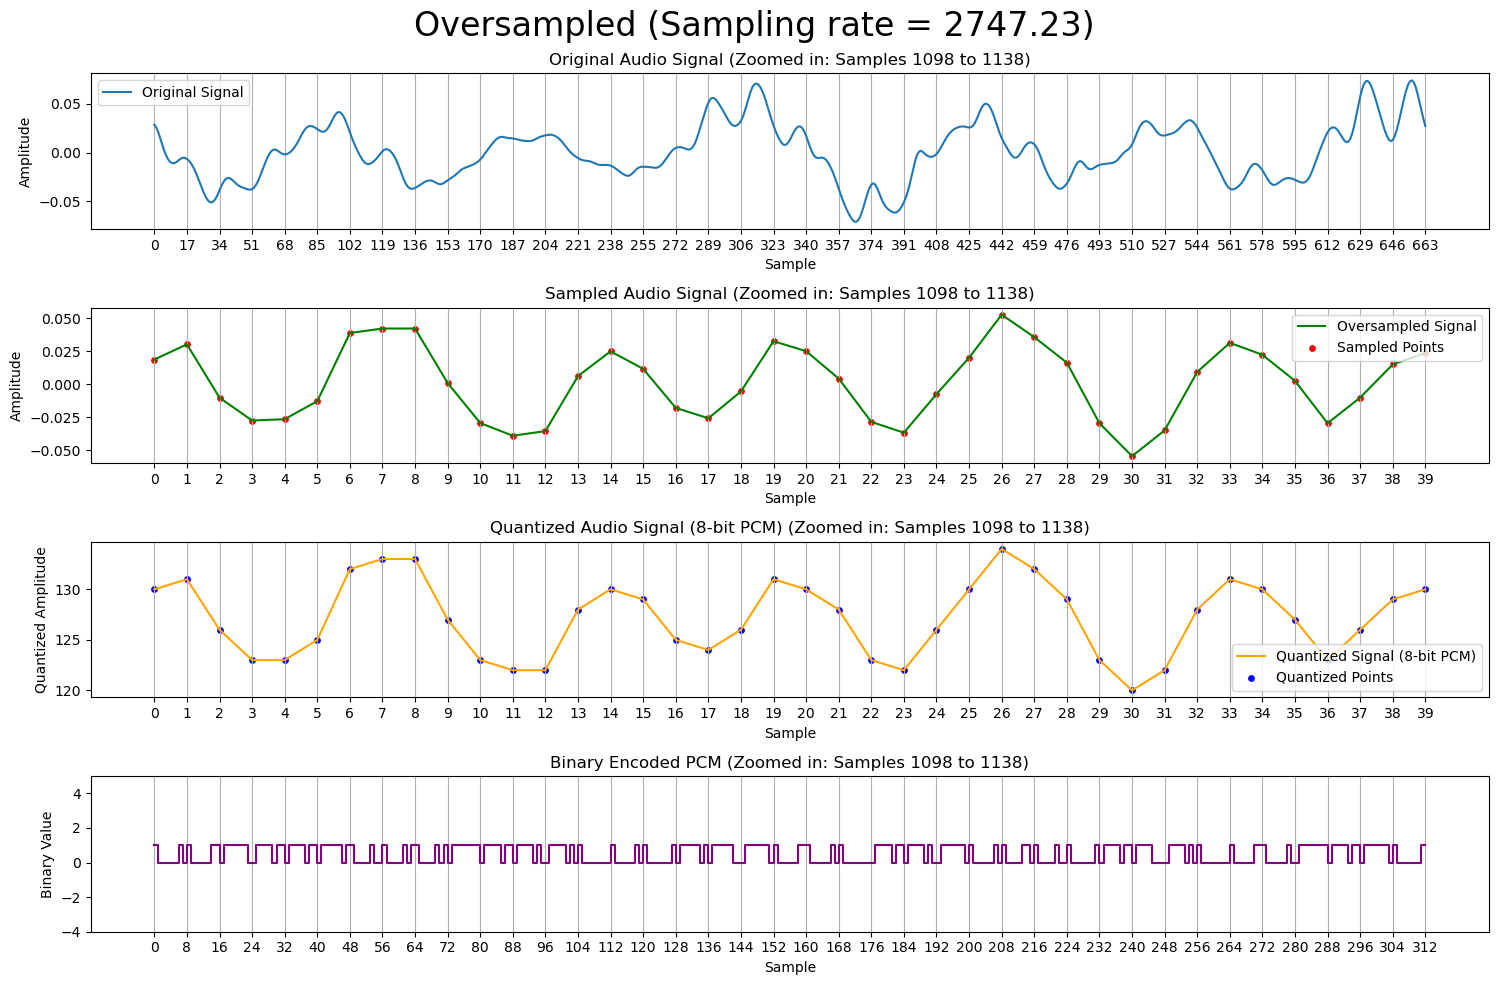

In [16]:
start_sample = int(start_sample_time * oversampled_sr)
end_sample = start_sample + sample_size
c_r = int(sr/oversampled_sr)

plt.figure(figsize=(15, 10))

# Plot 1: Original Signal
plt.subplot(4, 1, 1)
plt.plot(y[start_sample*c_r:(end_sample-1)*c_r+1], label="Original Signal")
plt.xticks(np.arange(0, sample_size*c_r, c_r))
plt.title(f"Original Audio Signal (Zoomed in: Samples {start_sample} to {end_sample})")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True, axis="x")
plt.legend()

# Plot 2: Sampled Signal
plt.subplot(4, 1, 2)
plt.plot(y_oversampled[start_sample:end_sample], label="Oversampled Signal", color='green')
plt.scatter(np.arange(0, len(y_over_quantized[start_sample:end_sample])), y_oversampled[start_sample:end_sample], color='red', label="Sampled Points", s=15)
plt.xticks(np.arange(0, sample_size, 1))
plt.title(f"Sampled Audio Signal (Zoomed in: Samples {start_sample} to {end_sample})")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True, axis="x")
plt.legend()

# Plot 3: Quantized Signal
plt.subplot(4, 1, 3)
plt.plot(y_over_quantized[start_sample:end_sample], label="Quantized Signal (8-bit PCM)", color='orange')
plt.scatter(np.arange(0, len(y_over_quantized[start_sample:end_sample])), y_over_quantized[start_sample:end_sample], color='blue', label="Quantized Points", s=15)
plt.xticks(np.arange(0, sample_size, 1))
plt.title(f"Quantized Audio Signal (8-bit PCM) (Zoomed in: Samples {start_sample} to {end_sample})")
plt.xlabel("Sample")
plt.ylabel("Quantized Amplitude")
plt.grid(True, axis="x")
plt.legend()

# Plot 4: Binary Encoded PCM
plt.subplot(4, 1, 4)
plt.step(np.arange(0, (sample_size-1)*num_bits+1), oversampled_binary_matrix[start_sample*num_bits:(end_sample-1)*num_bits+1], where='post', color='purple')
plt.xticks(np.arange(0, sample_size*num_bits, num_bits))
plt.title(f"Binary Encoded PCM (Zoomed in: Samples {start_sample} to {end_sample})")
plt.xlabel("Sample")
plt.ylabel("Binary Value")
plt.ylim(-(sample_size/num_bits)+1, sample_size/num_bits)
plt.grid(True, axis="x")

plt.suptitle(f"Oversampled (Sampling rate = {oversampled_sr:.2f})", fontsize=24)

plt.tight_layout()
plt.show()

### Demodulating the PCM signals

In [17]:
# Reverse the binary PCM back to quantized amplitude values
y_under_demodulated_quantized = []
y_demodulated_quantized = []
y_over_demodulated_quantized = []

for i in range(0, len(undersampled_binary_matrix), num_bits):
    binary_string = ''.join([str(bit) for bit in undersampled_binary_matrix[i:i+num_bits]])
    y_under_demodulated_quantized.append(int(binary_string, 2))

for i in range(0, len(binary_matrix), num_bits):
    binary_string = ''.join([str(bit) for bit in binary_matrix[i:i+num_bits]])
    y_demodulated_quantized.append(int(binary_string, 2))

for i in range(0, len(oversampled_binary_matrix), num_bits):
    binary_string = ''.join([str(bit) for bit in oversampled_binary_matrix[i:i+num_bits]])
    y_over_demodulated_quantized.append(int(binary_string, 2))

# Convert to numpy array for further processing
y_under_demodulated_quantized = np.array(y_under_demodulated_quantized)
y_demodulated_quantized = np.array(y_demodulated_quantized)
y_over_demodulated_quantized = np.array(y_over_demodulated_quantized)

# De-normalization: Convert back from quantized values to normalized values in range [-1, 1]
y_under_demodulated_normalized = (y_under_demodulated_quantized / (quantization_levels / 2 - 1)) - 1
y_demodulated_normalized = (y_demodulated_quantized / (quantization_levels / 2 - 1)) - 1
y_over_demodulated_normalized = (y_over_demodulated_quantized / (quantization_levels / 2 - 1)) - 1

### Plotting the original sampled vs. demodulated signal in the same graph

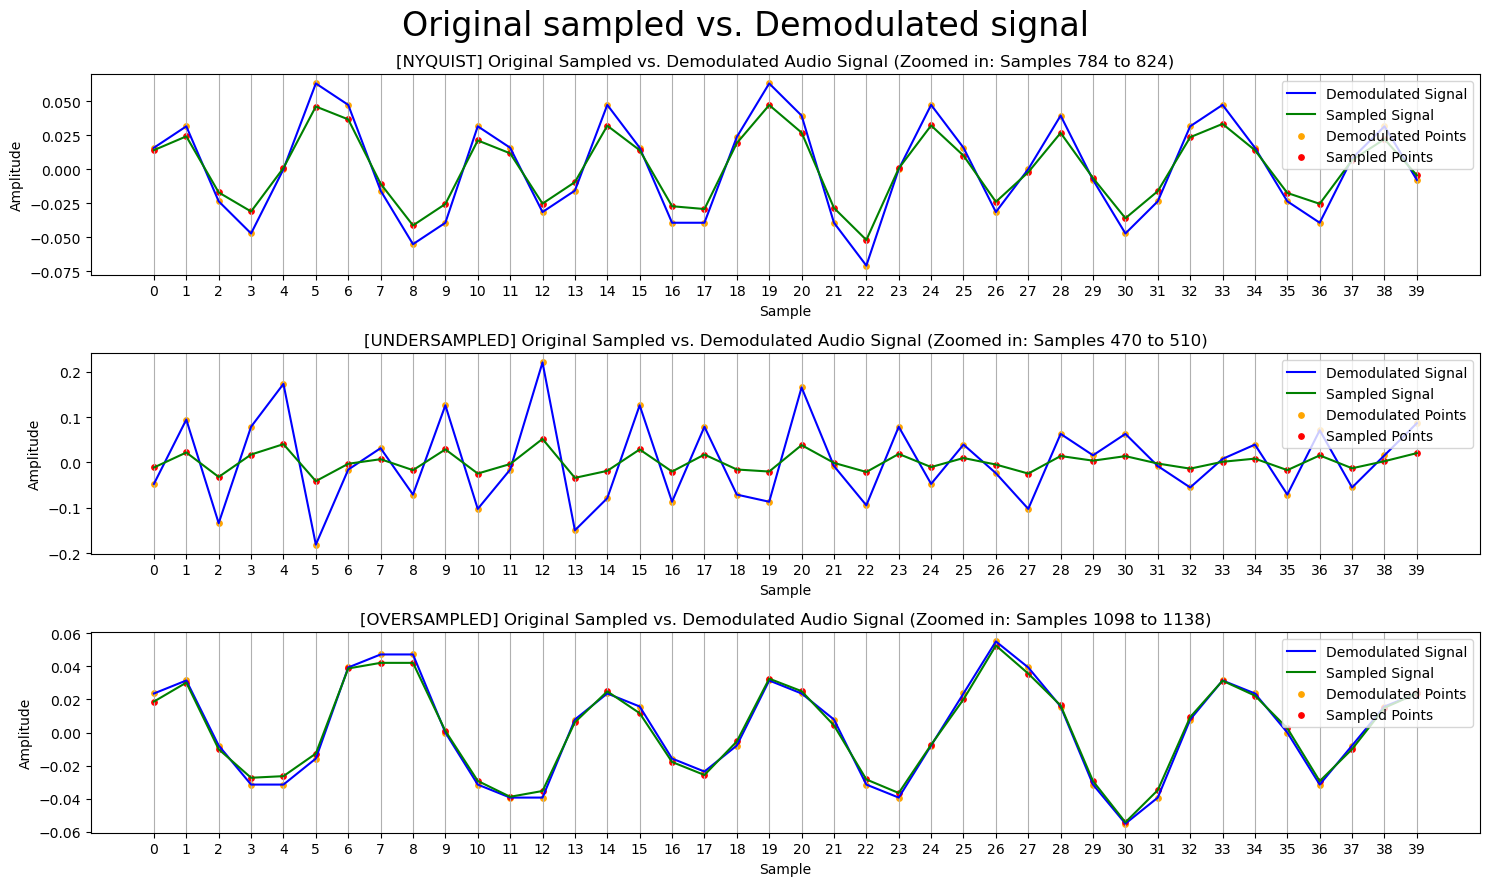

In [18]:
# Compare the demodulated signal with the sampled signal
plt.figure(figsize=(15, 9))

# Plot the original sampled vs. demodulated signal for Nyquist
start_sample = int(start_sample_time * target_sr)
end_sample = start_sample + sample_size
c_r = int(sr/target_sr)

plt.subplot(3, 1, 1)
plt.plot(y_demodulated_normalized[start_sample:end_sample], label="Demodulated Signal", color='blue')
plt.plot(y_resampled[start_sample:end_sample], label="Sampled Signal", color='green')
plt.scatter(np.arange(0, sample_size), y_demodulated_normalized[start_sample:end_sample], color='orange', label="Demodulated Points", s=15)
plt.scatter(np.arange(0, sample_size), y_resampled[start_sample:end_sample], color='red', label="Sampled Points", s=15)
plt.title(f"[NYQUIST] Original Sampled vs. Demodulated Audio Signal (Zoomed in: Samples {start_sample} to {end_sample})")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.xticks(np.arange(0, sample_size, 1))
plt.grid(True, axis="x")
plt.legend()

# Plot the original sampled vs. demodulated signal for Undersampled
start_sample = int(start_sample_time * undersampled_sr)
end_sample = start_sample + sample_size
c_r = int(sr/undersampled_sr)

plt.subplot(3, 1, 2)
plt.plot(y_under_demodulated_normalized[start_sample:end_sample], label="Demodulated Signal", color='blue')
plt.plot(y_undersampled[start_sample:end_sample], label="Sampled Signal", color='green')
plt.scatter(np.arange(0, sample_size), y_under_demodulated_normalized[start_sample:end_sample], color='orange', label="Demodulated Points", s=15)
plt.scatter(np.arange(0, sample_size), y_undersampled[start_sample:end_sample], color='red', label="Sampled Points", s=15)
plt.title(f"[UNDERSAMPLED] Original Sampled vs. Demodulated Audio Signal (Zoomed in: Samples {start_sample} to {end_sample})")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.xticks(np.arange(0, sample_size, 1))
plt.grid(True, axis="x")
plt.legend()

# Plot the original sampled vs. demodulated signal for Oversampled
start_sample = int(start_sample_time * oversampled_sr)
end_sample = start_sample + sample_size
c_r = int(sr/oversampled_sr)

plt.subplot(3, 1, 3)
plt.plot(y_over_demodulated_normalized[start_sample:end_sample], label="Demodulated Signal", color='blue')
plt.plot(y_oversampled[start_sample:end_sample], label="Sampled Signal", color='green')
plt.scatter(np.arange(0, sample_size), y_over_demodulated_normalized[start_sample:end_sample], color='orange', label="Demodulated Points", s=15)
plt.scatter(np.arange(0, sample_size), y_oversampled[start_sample:end_sample], color='red', label="Sampled Points", s=15)
plt.title(f"[OVERSAMPLED] Original Sampled vs. Demodulated Audio Signal (Zoomed in: Samples {start_sample} to {end_sample})")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.xticks(np.arange(0, sample_size, 1))
plt.grid(True, axis="x")
plt.legend()

plt.suptitle(f"Original sampled vs. Demodulated signal", fontsize=24)

plt.tight_layout()
plt.show()

### Plotting the original vs. reconstructed signal in the same graph

In [19]:
# Resample the demodulated signal back to the original sampling rate
y_under_reconstructed = librosa.resample(y_under_demodulated_normalized, orig_sr=undersampled_sr, target_sr=sr)
y_reconstructed = librosa.resample(y_demodulated_normalized, orig_sr=target_sr, target_sr=sr)
y_over_reconstructed = librosa.resample(y_over_demodulated_normalized, orig_sr=oversampled_sr, target_sr=sr)

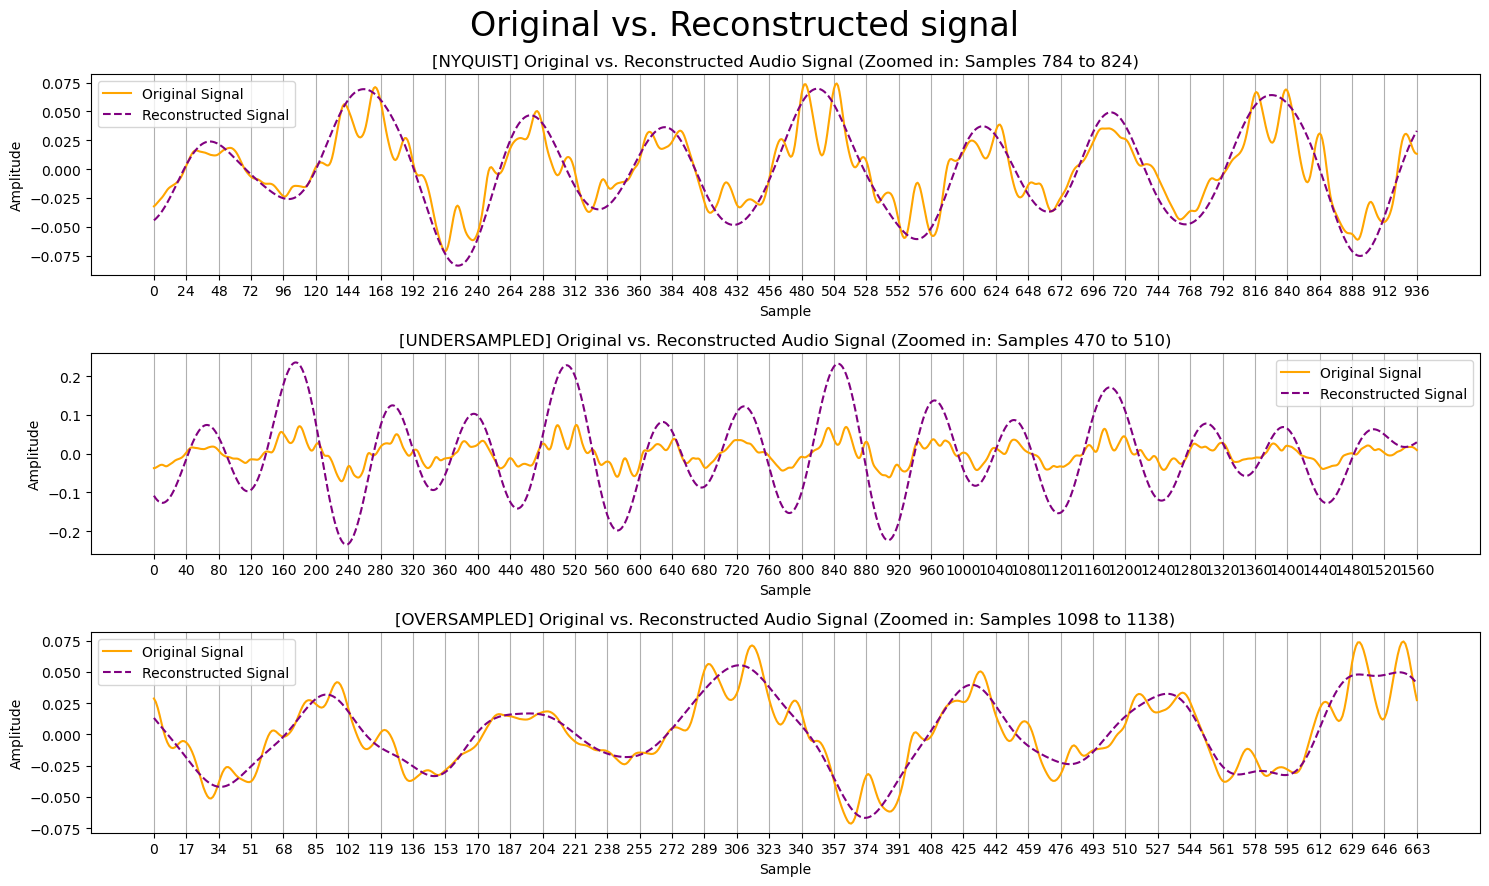

In [20]:
plt.figure(figsize=(15, 9))

# Nyquist
start_sample = int(start_sample_time * target_sr)
end_sample = start_sample + sample_size
c_r = int(sr/target_sr)

plt.subplot(3, 1, 1)
plt.plot(y[start_sample*c_r:(end_sample-1)*c_r+1], label="Original Signal", color='orange', linewidth=1.5)
plt.plot(y_reconstructed[start_sample*c_r:(end_sample-1)*c_r+1], label="Reconstructed Signal", color='purple', linestyle='--', linewidth=1.5)
plt.title(f"[NYQUIST] Original vs. Reconstructed Audio Signal (Zoomed in: Samples {start_sample} to {end_sample})")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.xticks(np.arange(0, sample_size*c_r, c_r))
plt.grid(True, axis="x")
plt.legend()

# Undersampled
start_sample = int(start_sample_time * undersampled_sr)
end_sample = start_sample + sample_size
c_r = int(sr/undersampled_sr)

plt.subplot(3, 1, 2)
plt.plot(y[start_sample*c_r:(end_sample-1)*c_r+1], label="Original Signal", color='orange', linewidth=1.5)
plt.plot(y_under_reconstructed[start_sample*c_r:(end_sample-1)*c_r+1], label="Reconstructed Signal", color='purple', linestyle='--', linewidth=1.5)
plt.title(f"[UNDERSAMPLED] Original vs. Reconstructed Audio Signal (Zoomed in: Samples {start_sample} to {end_sample})")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.xticks(np.arange(0, sample_size*c_r, c_r))
plt.grid(True, axis="x")
plt.legend()

# Oversampled
start_sample = int(start_sample_time * oversampled_sr)
end_sample = start_sample + sample_size
c_r = int(sr/oversampled_sr)

plt.subplot(3, 1, 3)
plt.plot(y[start_sample*c_r:(end_sample-1)*c_r+1], label="Original Signal", color='orange', linewidth=1.5)
plt.plot(y_over_reconstructed[start_sample*c_r:(end_sample-1)*c_r+1], label="Reconstructed Signal", color='purple', linestyle='--', linewidth=1.5)
plt.title(f"[OVERSAMPLED] Original vs. Reconstructed Audio Signal (Zoomed in: Samples {start_sample} to {end_sample})")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.xticks(np.arange(0, sample_size*c_r, c_r))
plt.grid(True, axis="x")
plt.legend()

plt.suptitle(f"Original vs. Reconstructed signal", fontsize=24)

plt.tight_layout()
plt.show()

### Displaying statistics (Mean Squared Error and Correlation Coefficient)

In [21]:
# Nyquist
print(f"Statistics for Nyquist sample rate modulated signal")
mse = mean_squared_error(y, y_reconstructed[:len(y)])
print(f"- Mean Squared Error (MSE): {mse:.5f}")
correlation_coefficient, _ = pearsonr(y, y_reconstructed[:len(y)])
print(f"- Correlation Coefficient: {correlation_coefficient:.5f}")

# Undersampled
print(f"\nStatistics for Undersampled modulated signal")
mse = mean_squared_error(y, y_under_reconstructed[:len(y)])
print(f"- Mean Squared Error (MSE): {mse:.5f}")
correlation_coefficient, _ = pearsonr(y, y_under_reconstructed[:len(y)])
print(f"- Correlation Coefficient: {correlation_coefficient:.5f}")

# Oversampled
print(f"\nStatistics for Oversampled modulated signal")
mse = mean_squared_error(y, y_over_reconstructed[:len(y)])
print(f"- Mean Squared Error (MSE): {mse:.5f}")
correlation_coefficient, _ = pearsonr(y, y_over_reconstructed[:len(y)])
print(f"- Correlation Coefficient: {correlation_coefficient:.5f}")

Statistics for Nyquist sample rate modulated signal
- Mean Squared Error (MSE): 0.02196
- Correlation Coefficient: 0.63186

Statistics for Undersampled modulated signal
- Mean Squared Error (MSE): 0.04910
- Correlation Coefficient: 0.22142

Statistics for Oversampled modulated signal
- Mean Squared Error (MSE): 0.01153
- Correlation Coefficient: 0.80912


### Downloading

In [22]:
sf.write('Demodulated_nyquist_Recording.wav', y_reconstructed, sr)
sf.write('Demodulated_undersampled_Recording.wav', y_under_reconstructed, sr)
sf.write('Demodulated_oversampled_Recording.wav', y_over_reconstructed, sr)